Below is an implementation of a Variational Autoencoder (VAE) with a Convolutional Neural Network (CNN) architecture for the MNIST dataset using PyTorch. The encoder uses a Gaussian distribution, and the decoder and loss functions are modular to allow users to choose between multiple distributions:

- **Gaussian with fixed variance**
- **Gaussian with learned variance**
- **Bernoulli**
- **Continuous Bernoulli**
- **Beta VAE**


This implementation includes modular components for each distribution, allowing you to easily switch between them.



In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torch.optim as optim
from torch.distributions import Normal, kl_divergence
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision.utils import save_image, make_grid
import numpy as np
from tqdm import tqdm


In [74]:
# Encoder network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=4, stride=2, padding=1
        )  # (batch, 1, 28, 28) -> (batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=4, stride=2, padding=1
        )  # (batch, 32, 14, 14) -> (batch, 64, 7, 7)
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [75]:
# Bernoulli decoder
# The handwritten digits are `close’ to binary-valued, but are in fact continuous-valued.
# See histogrram of pixel values in the MNIST dataset.
class BernoulliDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(BernoulliDecoder, self).__init__()
        # Fully connected layer
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        # Transposed convolutions
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # (batch, 64, 7, 7) -> (batch, 32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=4, stride=2, padding=1
        )  # (batch, 32, 14, 14) -> (batch, 1, 28, 28)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)  # Reshape
        x = F.relu(self.deconv1(x))
        x = self.deconv2(
            x
        )  # Do not use sigmoid to Output in (0,1) for Bernoulli as this is handled by the loss function
        # **Problem:** Applying the sigmoid activation separately can lead to numerical
        # instability, especially when the inputs have extreme values. Additionally,
        # it requires an extra computation step.
        return x


In [76]:
# Gaussian decoder with fixed variance
class GaussianDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(GaussianDecoder, self).__init__()
        # Fully connected layer to expand latent vector
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        # Deconvolutional layers to reconstruct the image
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # Upsamples from (64, 7, 7) to (32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1
        )  # Upsamples from (32, 14, 14) to (1, 28, 28)

    def forward(self, z):
        # Fully connected layer to expand z
        x = self.fc(z)
        # Reshape into feature maps
        x = x.view(-1, 64, 7, 7)
        # Deconvolution layers with activations
        x = F.relu(self.deconv1(x))
        # Final deconvolution layer; no activation function
        x = self.deconv2(x)
        # Output is (batch_size, 1, 28, 28)
        return x  # Outputting raw values; no activation function


In [77]:
class GaussianDecoderLearnedVariance(nn.Module):
    def __init__(self, latent_dim):
        super(GaussianDecoderLearnedVariance, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)
        self.final_mu = nn.Conv2d(32, 1, kernel_size=1)
        self.final_logvar = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        recon_mu = self.final_mu(x)
        recon_logvar = self.final_logvar(x)
        # Apply softplus activation to ensure positive variance

        #        - **Unbounded `recon_logvar`**: The decoder outputs `recon_logvar` without any activation function, meaning it can take any real value, including large negative values.
        # - **Small Variance**: Large negative values of `recon_logvar` correspond to extremely small variances after applying the exponential function.
        # - **High PDF Values**: With very small variances, the Gaussian PDF becomes extremely peaked, leading to high values for `log_prob` when the input `x` is close to `recon_mu`.
        # - **Negative NLL**: This results in negative values for the NLL, which is unexpected since the NLL should be non-negative in practical scenarios.
        #   - **Softplus Function**: \( \text{softplus}(x) = \ln(1 + e^{x}) \), which outputs values greater than 0 for real inputs.
        recon_logvar = F.softplus(recon_logvar)
        return recon_mu, recon_logvar

In [78]:
class ContinuousBernoulliDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ContinuousBernoulliDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        logits = self.deconv2(x)
        lambda_param = torch.sigmoid(logits)
        return lambda_param  # Output λ parameter for continuous Bernoulli


In [79]:
# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim=2, distribution="bernoulli"):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.latent_dim = latent_dim
        self.distribution = distribution

        # Select decoder based on distribution
        if distribution == "bernoulli":
            self.decoder = BernoulliDecoder(latent_dim)
        elif distribution == "gaussian":
            self.decoder = GaussianDecoder(latent_dim)
        elif distribution == "gaussian_with_learned_variance":
            self.decoder = GaussianDecoderLearnedVariance(latent_dim)
        elif distribution == "continuous_bernoulli":
            self.decoder = ContinuousBernoulliDecoder(latent_dim)
        else:
            raise NotImplementedError(
                f"Decoder for distribution '{distribution}' is not implemented."
            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random tensor with same shape as std
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        if self.distribution == "gaussian_with_learned_variance":
            recon_mean, recon_logvar = self.decoder(z)
            return (recon_mean, recon_logvar), mu, logvar
        else:
            recon = self.decoder(z)
        return recon, mu, logvar


In [80]:
# Check for GPU or MPS availability. Use CPU if neither is available.
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


In [81]:
def atanh(x):
    epsilon = 1e-7
    return 0.5 * torch.log((1 + x) / (1 - x + epsilon))


def log_c_lambda(lambda_param):
    epsilon = 1e-7
    lambda_param = lambda_param.clamp(epsilon, 1 - epsilon)
    one_minus_two_lambda = 1 - 2 * lambda_param
    near_half = (lambda_param - 0.5).abs() < 0.003
    log_c = torch.zeros_like(lambda_param)
    # Approximation near λ=0.5
    log_c[near_half] = (
        torch.log(torch.tensor(2.0)) + ((lambda_param[near_half] - 0.5) ** 2) / 6
    )
    # Exact calculation elsewhere
    lmb = lambda_param[~near_half]
    one_minus_two_lmb = 1 - 2 * lmb
    numerator = 2 * atanh(one_minus_two_lmb)
    denominator = one_minus_two_lmb + epsilon
    c_lmb = numerator / (denominator + epsilon)
    log_c[~near_half] = torch.log(c_lmb + epsilon)
    return log_c

In [82]:
# Loss function with modularity for different distributions
def loss_function(recon_x, x, mu, logvar, distribution="bernoulli"):
    """
    Compute the loss function for a VAE with different output distributions.
    Args:
        recon_x: reconstructed input from the decoder
        x: input data
        mu: mean of the latent distribution
        logvar: log variance of the latent distribution
        distribution: output distribution of the VAE
    Returns:
        loss: the loss value
    """
    batch_size = x.size(0)
    # Compute Kullback-Leibler divergence term (using torch.distributions)
    q_z = Normal(loc=mu, scale=(0.5 * logvar).exp())
    p_z = Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))
    KLD = kl_divergence(q_z, p_z).sum()
    KLD /= batch_size  # Normalize by batch size

    if distribution == "bernoulli":
        # Assert that shapes are the same
        assert recon_x.shape == x.shape

        # Flatten recon_x and x to [batch_size, 784]
        recon_x = recon_x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        # Reconstruction loss (using logits and no sigmoid in decoder output)
        BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction="sum")
        BCE /= batch_size  # Normalize by batch size
        return BCE + KLD

    elif distribution == "gaussian":
        # Flatten recon_x and x to [batch_size, 784]
        recon_x = recon_x.view(batch_size, -1)
        x = x.view(batch_size, -1)

        # Reconstruction loss (assuming a fixed variance, can use MSE)
        MSE = F.mse_loss(recon_x, x, reduction="sum")
        MSE /= batch_size  # Normalize by batch size

        return MSE + KLD

    elif distribution == "gaussian_with_learned_variance":
        recon_mu, recon_logvar = recon_x
        recon_mu = recon_mu.view(batch_size, -1)
        recon_logvar = recon_logvar.view(batch_size, -1)
        x = x.view(batch_size, -1)
        # Ensure that the variance used in the `Normal` distribution doesn't become too small,
        # which can be done by clamping the standard deviation:
        recon_std = torch.exp(0.5 * recon_logvar).clamp(min=1e-3)
        recon_dist = Normal(recon_mu, recon_std)
        NLL = -recon_dist.log_prob(x)
        NLL = NLL.sum() / batch_size

        return NLL + KLD

    elif distribution == "continuous_bernoulli":
        # lambda_param = recon_x
        # lambda_param = lambda_param.view(batch_size, -1)
        # x = x.view(batch_size, -1)
        # epsilon = 1e-7
        # log_lambda = torch.log(lambda_param + epsilon)
        # log_one_minus_lambda = torch.log(1 - lambda_param + epsilon)
        # log_c = log_c_lambda(lambda_param)
        # # Compute negative log-likelihood
        # NLL = (
        #     -(log_c + x * log_lambda + (1 - x) * log_one_minus_lambda).sum()
        #     / batch_size
        # )
        # return NLL + KLD
        # # Continuous Bernoulli negative log-likelihood
        epsilon = 1e-6  # Small constant to avoid division by zero
        recon_x = torch.clamp(recon_x, epsilon, 1 - epsilon)
        x = torch.clamp(x, epsilon, 1 - epsilon)
        # Negative log-likelihood for continuous Bernoulli

        # check agains this implementation: https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE/blob/master/utils.py

        C = 2 * torch.atanh(1 - 2 * recon_x) / (1 - 2 * recon_x + epsilon)
        NLL = -torch.sum(
            x * torch.log(recon_x)
            + (1 - x) * torch.log(1 - recon_x)
            + torch.log(C + epsilon)
        )
        return NLL + KLD
    else:
        raise NotImplementedError(
            f"Loss function for distribution '{distribution}' is not implemented."
        )



**Explanation:**

- **Encoder**: A CNN-based encoder that outputs the mean (`mu`) and log-variance (`logvar`) for the Gaussian latent variables.
- **Decoders**: Multiple decoders are implemented based on the distribution:
  - **BernoulliDecoder**: Outputs probabilities for each pixel, suitable for binary data.
  - **GaussianDecoder**: Outputs mean and log-variance for each pixel, suitable for continuous data.
  - **ContinuousBernoulliDecoder**: Uses the same architecture as `BernoulliDecoder` but with a different loss function.
  - **CategoricalDecoder**: Outputs logits corresponding to the 10 classes in MNIST.
- **VAE**: Central class that integrates the encoder and the chosen decoder. It includes the reparameterization trick.
- **Loss Function**: Modular loss function that computes the reconstruction loss and the KL divergence term based on the distribution.

**Training Loop Example:**

Here's how you can use the VAE to train on the MNIST dataset:


In [83]:
# Hyperparameters
latent_dim = 2
distribution = "bernoulli"  # Choose between 'bernoulli', 'gaussian', 'gaussian_with_learned_variance', continuous_bernoulli'
beta = 1.0  # For Beta VAE
batch_size = 128  # TODO Extract to hyperparameters
learning_rate = 1e-3


## MNIST Preprocessing as described in Appendix 4
# in this paper: https://arxiv.org/src/1907.06845v4/anc/cont_bern_aux.pdf

# PYtorch v2 is used for the preprocessing and is generally faster than the torchvision.transforms
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


# How should we transform the data for the gaussian distribution?
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Scales images to [0,1]
#     transforms.Normalize((0.5,), (0.5,))  # Normalizes images to [-1,1]
# ])
# or
# Calculate mean and standard deviation
# data = next(iter(train_loader))[0]
# mean = data.mean().item()
# std = data.std().item()
# and use those to transform the data
# print("Mean:", mean)
# print("Standard Deviation:", std)

# further ideas
# transforms.RandomRotation(10),  # Data augmentation

full_train_dataset = datasets.MNIST(
    root="./data", train=True, download=False, transform=transform
)

# Split the training data into training and validation sets (80% training, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

CUDA = torch.cuda.is_available()
# DataLoader instances will load tensors directly into GPU memory
kwargs = {"num_workers": 1, "pin_memory": True} if CUDA else {}

# Create data loaders
# Pin memory only if using GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# load TEST data set
test_dataset = datasets.MNIST(
    root="./data", train=False, download=False, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)


# Model and optimizer
model = VAE(latent_dim=latent_dim, distribution=distribution).to(device)
# Dr Diederik Kingma: as if VAEs weren't enough, he also gave us Adam!
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary using torchinfo
print(summary(model, input_size=(batch_size, 1, 28, 28), device=str(device)))


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 1, 28, 28]          --
├─Encoder: 1-1                           [128, 2]                  --
│    └─Conv2d: 2-1                       [128, 32, 14, 14]         544
│    └─Conv2d: 2-2                       [128, 64, 7, 7]           32,832
│    └─Linear: 2-3                       [128, 2]                  6,274
│    └─Linear: 2-4                       [128, 2]                  6,274
├─BernoulliDecoder: 1-2                  [128, 1, 28, 28]          --
│    └─Linear: 2-5                       [128, 3136]               9,408
│    └─ConvTranspose2d: 2-6              [128, 32, 14, 14]         32,800
│    └─ConvTranspose2d: 2-7              [128, 1, 28, 28]          513
Total params: 88,645
Trainable params: 88,645
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.10
Input size (MB): 0.40
Forward/backward pass size (MB): 20.07
Params size (MB): 0.35
Estimated To

In [84]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, targets) in enumerate(
        tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    ):
        x = data.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar, distribution=distribution)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")


Epoch 0/10: 100%|██████████| 375/375 [00:05<00:00, 64.80it/s]


Epoch 1, Loss: 1.6412834059397379


Epoch 1/10: 100%|██████████| 375/375 [00:05<00:00, 67.65it/s]


Epoch 2, Loss: 1.3573887567520142


Epoch 2/10: 100%|██████████| 375/375 [00:05<00:00, 67.91it/s]


Epoch 3, Loss: 1.3083336674372354


Epoch 3/10: 100%|██████████| 375/375 [00:05<00:00, 67.35it/s]


Epoch 4, Loss: 1.2783987436294555


Epoch 4/10: 100%|██████████| 375/375 [00:05<00:00, 67.54it/s]


Epoch 5, Loss: 1.2579233846664428


Epoch 5/10: 100%|██████████| 375/375 [00:05<00:00, 67.04it/s]


Epoch 6, Loss: 1.24292875289917


Epoch 6/10: 100%|██████████| 375/375 [00:05<00:00, 66.40it/s]


Epoch 7, Loss: 1.2309540246327717


Epoch 7/10: 100%|██████████| 375/375 [00:05<00:00, 64.39it/s]


Epoch 8, Loss: 1.221123943010966


Epoch 8/10: 100%|██████████| 375/375 [00:06<00:00, 61.43it/s]


Epoch 9, Loss: 1.2130192422866821


Epoch 9/10: 100%|██████████| 375/375 [00:05<00:00, 65.42it/s]

Epoch 10, Loss: 1.2068084907531738


In [70]:
def plot_images(images, nrow):
    # Create a grid of images using make_grid
    grid_img = make_grid(images, nrow=nrow, padding=2)
    # Transpose dimensions to [height, width, channels]
    plt.imshow(grid_img.numpy().transpose(1, 2, 0), cmap="gray")

    plt.axis("off")
    plt.show()


In [71]:
# Assuming 'model' is your trained VAE and 'device' is the torch device (CPU or GPU)
# Also assuming the VAE model consists of 'encoder' and 'decoder' components


def sample_and_plot_with_make_grid(model, num_samples=16, nrow=4):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients during inference
        # Get the latent dimension from the model (assuming encoder's fc_mu defines latent dim)
        latent_dim = 2  # model.encoder.fc_mu.out_features

        # Sample latent vectors z from the standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(
            device
        )  # Shape: [num_samples, latent_dim]

        # Pass z through the decoder to reconstruct images
        reconstructed_images = model.decoder(
            z
        )  # Output shape: [num_samples, 1, 28, 28]

        # Apply sigmoid activation to get pixel values in (0, 1)
        # suitable for Bernoulli distribution, gaussian distribution with fixed variance
        reconstructed_images = torch.sigmoid(
            reconstructed_images
        )  # Shape: [num_samples, 1, 28, 28]

        # Move the tensor to CPU and convert to numpy array
        images = reconstructed_images.cpu()

        # Plot the images
        plot_images(images, nrow=nrow)


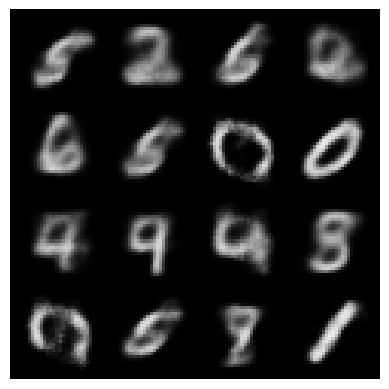

In [72]:
# Usage

model.to(device)
sample_and_plot_with_make_grid(model, num_samples=16, nrow=4)

In [68]:
def interpolate_and_plot(model, num_interpolations=10):
    model.eval()
    with torch.no_grad():
        latent_dim = 2
        # Sample two random latent vectors
        z_start = torch.randn(1, latent_dim).to(device)
        z_end = torch.randn(1, latent_dim).to(device)
        # Create interpolation vectors
        z_interpolated = [
            z_start * (1 - alpha) + z_end * alpha
            for alpha in torch.linspace(0, 1, num_interpolations)
        ]
        z_interpolated = torch.cat(z_interpolated, dim=0)
        # Decode interpolated latent vectors
        reconstructed_images = model.decoder(z_interpolated)
        # Process images
        images = torch.sigmoid(reconstructed_images)
        images = images.cpu().numpy()
        # Plot images
        plot_images(images)


# Usage example
interpolate_and_plot(model, num_interpolations=12)

TypeError: plot_images() missing 1 required positional argument: 'nrow'

### gaussian with learned variance

This code first samples latent vectors `z` from the prior, passes them through the decoder to get `recon_mu` and `recon_logvar`, and then either uses `recon_mu` directly or samples from the learned Gaussian distribution to generate images. The images are then processed (e.g., applying sigmoid to map values to [0, 1]) and plotted.

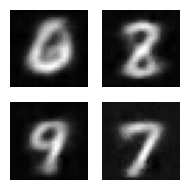

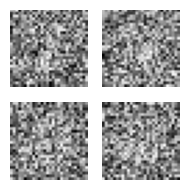

In [60]:
def sample_and_plot_mean(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Get latent dimension
        latent_dim = model.encoder.fc_mu.out_features

        # Sample z from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)

        # Decode to get recon_mu and recon_logvar
        recon_mu, recon_logvar = model.decoder(z)

        # Use recon_mu directly, apply sigmoid to map to [0, 1]
        images = torch.sigmoid(recon_mu)

        # Move to CPU and convert to numpy
        images = images.cpu().numpy()

        # Plot images
        plot_images(images)


def sample_and_plot_samples(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        # Get latent dimension
        latent_dim = model.encoder.fc_mu.out_features

        # Sample z from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)

        # Decode to get recon_mu and recon_logvar
        recon_mu, recon_logvar = model.decoder(z)

        # Compute standard deviation
        recon_std = torch.exp(0.5 * recon_logvar)

        # Sample from Gaussian
        epsilon = torch.randn_like(recon_std)
        recon_samples = recon_mu + recon_std * epsilon

        # Apply sigmoid to map to [0, 1]
        images = torch.sigmoid(recon_samples)

        # Move to CPU and convert to numpy
        images = images.cpu().numpy()

        # Plot images
        plot_images(images)


# Usage
model.to(device)

# Option 1: Use recon_mu directly
sample_and_plot_mean(model, num_samples=4)

# Option 2: Sample from the Gaussian distribution
sample_and_plot_samples(model, num_samples=4)

## PROBLEM with noise picture

I'm sorry to hear that you're encountering issues with Option 2 where sampling from the Gaussian decoder with learned variance results in images that appear as just noise. This is a common issue when working with VAEs where the learned variance (`recon_logvar`) leads to high variance (or standard deviation), causing the sampled images to be extremely noisy.

Let's investigate potential reasons for this problem and explore solutions to help you generate meaningful images when sampling from the learned Gaussian distribution.

---

## **Possible Reasons and Solutions**

### **1. High Variance Leading to Noisy Samples**

**Issue:**

- The learned variance (`recon_logvar`) may be too large, resulting in a high standard deviation (`recon_std`).
- When you sample from the Gaussian distribution \( \text{recon\_mu} + \text{recon\_std} \times \epsilon \), large values of `recon_std` can introduce significant noise, making the images appear random.

**Solution:**

- **Inspect `recon_logvar` and `recon_std` Values:**

  Before sampling, print out the statistics of `recon_logvar` and `recon_std` to see if they are reasonable.

  ```python
  print("Mean of recon_logvar:", recon_logvar.mean().item())
  print("Std of recon_logvar:", recon_logvar.std().item())
  print("Max of recon_logvar:", recon_logvar.max().item())
  print("Min of recon_logvar:", recon_logvar.min().item())

  recon_std = torch.exp(0.5 * recon_logvar)
  print("Mean of recon_std:", recon_std.mean().item())
  print("Std of recon_std:", recon_std.std().item())
  print("Max of recon_std:", recon_std.max().item())
  print("Min of recon_std:", recon_std.min().item())
  ```

- **Clamp or Restrict Variances:**

  Limit the maximum variance (or standard deviation) to prevent extremely large values.

  ```python
  recon_std = recon_std.clamp(max=1.0)  # Adjust the max value as appropriate
  ```

- **Apply a Scaling Factor:**

  Introduce a scaling factor to reduce the impact of the standard deviation.

  ```python
  scaling_factor = 0.1  # Experiment with different values
  recon_samples = recon_mu + scaling_factor * recon_std * epsilon
  ```

### **2. Variance Not Properly Learned**

**Issue:**

- The model may not have learned meaningful variances, causing the standard deviations to be uninformative or excessively large.

**Solution:**

- **Regularization:**

  Add a regularization term to the loss function to penalize large variances.

  ```python
  variance_penalty = (recon_std ** 2).mean()
  loss = NLL + KLD + beta * variance_penalty  # Choose an appropriate beta value
  ```

- **Ensure Proper Training:**

  Verify that the model is adequately trained and that the variance learning is happening correctly. Check the training loss curves and make sure the model converges.

### **3. Activation Functions and Constraints**

**Issue:**

- The lack of appropriate activation functions or constraints on `recon_logvar` can lead to negative variances or excessively high standard deviations.

**Solution:**

- **Use Softplus Activation:**

  Ensure that `recon_logvar` is processed through a softplus activation function to keep it positive and prevent numerical issues.

  ```python
  recon_logvar = F.softplus(recon_logvar) + 1e-6  # Ensure positive variance
  ```

- **Adjust Decoder Output:**

  Modify the decoder to output `recon_std` directly using a softplus activation, which guarantees positive values.

  ```python
  self.final_std = nn.Conv2d(32, 1, kernel_size=1)
  recon_std = F.softplus(self.final_std(x)) + 1e-6
  ```

### **4. Debugging the Sampling Code**

**Issue:**

- There may be a mistake in the sampling code, such as incorrect shapes or misapplied operations.

**Solution:**

- **Check Epsilon Generation:**

  Ensure that the random tensor `epsilon` has the same shape as `recon_std`.

  ```python
  epsilon = torch.randn_like(recon_std)
  ```

- **Inspect the Shapes:**

  Print out the shapes of `recon_mu`, `recon_std`, and `epsilon` to ensure they align.

  ```python
  print("Shape of recon_mu:", recon_mu.shape)
  print("Shape of recon_std:", recon_std.shape)
  print("Shape of epsilon:", epsilon.shape)
  ```

- **Verify the Sampling Equation:**

  Ensure that the sampling is implemented correctly.

  ```python
  recon_samples = recon_mu + recon_std * epsilon
  ```

### **5. Use `recon_mu` Directly for Visualization**

**Issue:**

- If the variance is not adding meaningful variation, using `recon_mu` directly may produce better images.

**Solution:**

- **Visualize `recon_mu` Only:**

  For visualization purposes, you might choose to use `recon_mu` directly, as it often produces clearer images.

  ```python
  images = torch.sigmoid(recon_mu)
  # Proceed to plot images
  ```

---

## **Implementing the Solutions**

Here's how you might adjust your code to address the issues:

### **Modified Sampling and Plotting Code**

```python
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def sample_and_plot_samples(model, num_samples=16, scaling_factor=0.1):
    model.eval()
    with torch.no_grad():
        latent_dim = model.encoder.fc_mu.out_features
        z = torch.randn(num_samples, latent_dim).to(device)
        recon_mu, recon_logvar = model.decoder(z)
        
        # Apply softplus to recon_logvar
        recon_logvar = F.softplus(recon_logvar) + 1e-6
        
        # Compute recon_std and clamp it
        recon_std = torch.exp(0.5 * recon_logvar)
        recon_std = recon_std.clamp(max=1.0)  # Adjust max value as needed
        
        # Sample from Gaussian
        epsilon = torch.randn_like(recon_std)
        recon_samples = recon_mu + scaling_factor * recon_std * epsilon  # Apply scaling factor
        
        # Apply sigmoid to map to [0, 1]
        images = torch.sigmoid(recon_samples)
        
        # Move to CPU and convert to numpy
        images = images.cpu().numpy()
        
        # Plot images
        plot_images(images)

def plot_images(images):
    num_images = images.shape[0]
    cols = int(num_images ** 0.5)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i, 0, :, :]
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
sample_and_plot_samples(model, num_samples=16, scaling_factor=0.1)
```

### **Adjustments Made:**

- **Applied `F.softplus` to `recon_logvar`** to ensure positive variance.

- **Clamped `recon_std`** to prevent excessively large values.

- **Introduced a `scaling_factor`** to reduce the impact of the standard deviation in the sampling process.

---

## **Next Steps**

### **1. Examine the Variance Values**

Check if the variance values are reasonable after the modifications.

```python
print("Mean of recon_std:", recon_std.mean().item())
print("Max of recon_std:", recon_std.max().item())
print("Min of recon_std:", recon_std.min().item())
```

A reasonable standard deviation should not be too large (e.g., not exceeding 1.0 significantly).

### **2. Retrain the Model if Necessary**

If the variance remains unreasonably high or the images are still noisy, consider retraining the model:

- **Adjust the Loss Function:**

  Add a penalty term for large variances.

  ```python
  variance_penalty = (recon_std ** 2).mean()
  loss = NLL + KLD + beta * variance_penalty  # Choose an appropriate beta
  ```

- **Monitor Training Losses:**

  Ensure that both the reconstruction loss and KL divergence are decreasing over epochs.

### **3. Use `recon_mu` for Visualization**

If sampling from the Gaussian distribution still doesn't produce meaningful images, you can use `recon_mu` directly:

```python
def sample_and_plot_mean(model, num_samples=16):
    model.eval()
    with torch.no_grad():
        latent_dim = model.encoder.fc_mu.out_features
        z = torch.randn(num_samples, latent_dim).to(device)
        recon_mu, _ = model.decoder(z)
        images = torch.sigmoid(recon_mu)
        images = images.cpu().numpy()
        plot_images(images)
```

---

## **Summary**

- The noisy images are likely due to high variance (standard deviation) when sampling from the Gaussian decoder with learned variance.

- To resolve this issue:

  - **Constrain the variance** using activation functions like softplus and clamping.

  - **Apply a scaling factor** to reduce the effect of high variance during sampling.

  - **Inspect the variance values** to ensure they are within a reasonable range.

- If necessary, **retrain the model** with adjustments to the loss function to encourage learning meaningful variances.

- For visualization purposes, using `recon_mu` directly may provide clearer images.

---

## **Final Note**

VAEs with learned variance can be sensitive to how the variance is handled during both training and sampling. It's important to ensure that the model learns meaningful variances and that the sampling process accounts for potential issues with high variance.

If you continue to experience issues, please share details about your training process, loss function, and any modifications you've made. This information can help in providing more specific guidance.

---

**Is there anything else I can assist you with?**

Great. How do I compare the different models and decide if one is performing better than the others?

Comparing different Variational Autoencoder (VAE) models to determine which one performs better involves both quantitative metrics and qualitative assessments. Since VAEs are generative models, evaluating them requires looking beyond traditional metrics used for discriminative models. Below, I'll outline several methods you can use to compare your trained models:

---

### **1. Quantitative Metrics**

#### **a. Loss Components: Reconstruction Loss and KL Divergence**

During training, you can monitor the two main components of the VAE loss function:

- **Reconstruction Loss**: Measures how well the decoder reconstructs the input data from the latent representation.
- **KL Divergence (KLD)**: Measures how closely the learned latent distribution matches the prior distribution (usually a standard normal distribution).

**How to Use:**

- **Training Curves**: Plot the reconstruction loss and KLD separately over epochs for each model. This can give you insights into the learning dynamics.
  
  ```python
  # Example code snippet to store losses during training
  recon_losses = []
  kld_losses = []
  total_losses = []

  # Inside training loop
  recon_losses.append(recon_loss.item())
  kld_losses.append(KLD.item())
  total_losses.append(loss.item())
  ```

- **Final Values**: Compare the final values of these losses after training. A lower reconstruction loss indicates better reconstruction capabilities, while an appropriate KLD ensures meaningful latent space representations.

#### **b. Evidence Lower Bound (ELBO)**

The total loss (Reconstruction Loss + β * KLD) is an approximation of the negative Evidence Lower Bound (ELBO). Comparing the ELBO across models can indicate which model better explains the data.

- **Interpretation**: A higher ELBO (or a lower negative ELBO) suggests a better balance between reconstruction fidelity and latent space regularization.

#### **c. Likelihood Estimates**

Compute the log-likelihood of the test data under each model. Since exact computation is often intractable, techniques like Importance Sampling or the Monte Carlo estimate can be used.

- **Implementation Note**: This can be computationally intensive and may require additional coding effort.

#### **d. Reconstruction Error on Test Set**

Evaluate the reconstruction loss on a held-out test set.

- **How to Use**: After training, pass the test data through the encoder and decoder, compute the reconstruction loss, and compare across models.

---

### **2. Qualitative Assessments**

#### **a. Visualizing Reconstructions**

Compare how well each model reconstructs input images from the test set.

- **Procedure**:
  - Select a set of test images.
  - Pass them through each trained model to obtain the reconstructions.
  - Visualize and compare the original and reconstructed images side by side.

  ```python
  import matplotlib.pyplot as plt

  def visualize_reconstructions(model, test_loader, num_images=10):
      model.eval()
      with torch.no_grad():
          for batch in test_loader:
              if model.distribution == 'categorical':
                  x, _ = batch
              else:
                  x = batch
              x = x.to(device)
              if model.distribution == 'gaussian':
                  recon_mean, recon_logvar, _, _ = model(x)
                  recon_x = recon_mean
              else:
                  recon_x, _, _ = model(x)
              x = x.cpu()
              recon_x = recon_x.cpu()
              break  # Only need one batch
      fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
      for i in range(num_images):
          axes[0, i].imshow(x[i].squeeze(), cmap='gray')
          axes[0, i].axis('off')
          axes[1, i].imshow(recon_x[i].squeeze(), cmap='gray')
          axes[1, i].axis('off')
      plt.suptitle(f'Reconstructions - {model.distribution}')
      plt.show()
  ```

- **Interpretation**: Sharper and more accurate reconstructions indicate better performance.

#### **b. Generating New Samples**

Sample from the prior latent distribution and pass these samples through the decoder to generate new images.

- **Procedure**:
  - Sample latent vectors `z` from a standard normal distribution.
  - Use the decoder to generate images from these latent vectors.
  - Visualize the generated images.

  ```python
  def generate_samples(model, num_samples=10):
      model.eval()
      with torch.no_grad():
          z = torch.randn(num_samples, model.latent_dim).to(device)
          if model.distribution == 'gaussian':
              recon_mean, recon_logvar = model.decoder(z)
              samples = recon_mean.cpu()
          else:
              samples = model.decoder(z).cpu()
      fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
      for i in range(num_samples):
          axes[i].imshow(samples[i].squeeze(), cmap='gray')
          axes[i].axis('off')
      plt.suptitle(f'Generated Samples - {model.distribution}')
      plt.show()
  ```

- **Interpretation**: More realistic and diverse samples indicate a better generative model.

#### **c. Latent Space Visualization**

Visualizing the structure of the latent space can provide insights into how well the model has learned meaningful representations.

- **Methods**:
  - **2D or 3D Latent Space**: If the latent dimension is 2 or 3, you can plot the latent representations directly.
  - **Dimensionality Reduction**: Use techniques like t-SNE or PCA to reduce higher-dimensional latent spaces to 2D for visualization.

  ```python
  from sklearn.manifold import TSNE

  def visualize_latent_space(model, test_loader, num_points=1000):
      model.eval()
      zs = []
      labels = []
      with torch.no_grad():
          for batch in test_loader:
              x, y = batch
              x = x.to(device)
              mu, _ = model.encoder(x)
              zs.append(mu.cpu())
              labels.extend(y.cpu())
              if len(labels) >= num_points:
                  break
      zs = torch.cat(zs)[:num_points]
      labels = labels[:num_points]
      zs_embedded = TSNE(n_components=2).fit_transform(zs)
      plt.scatter(zs_embedded[:, 0], zs_embedded[:, 1], c=labels, cmap='tab10', s=5)
      plt.colorbar()
      plt.title(f'Latent Space - {model.distribution}')
      plt.show()
  ```

- **Interpretation**: A well-structured latent space where similar data points are close together suggests better representation learning.

#### **d. Latent Space Interpolation**

Interpolate between two latent vectors and observe how the generated images change.

- **Procedure**:
  - Select two data points and obtain their latent representations.
  - Interpolate between these latent vectors.
  - Generate images from the interpolated latent vectors.

  ```python
  def interpolate_latent_space(model, data_loader):
      model.eval()
      with torch.no_grad():
          x, _ = next(iter(data_loader))
          x = x.to(device)
          mu, _ = model.encoder(x[:2])  # Take two samples
          z1, z2 = mu
          alphas = torch.linspace(0, 1, steps=10)
          interpolated_z = torch.lerp(z1, z2, alphas[:, None].to(device))
          if model.distribution == 'gaussian':
              recon_mean, _ = model.decoder(interpolated_z)
              interpolated_images = recon_mean.cpu()
          else:
              interpolated_images = model.decoder(interpolated_z).cpu()
      fig, axes = plt.subplots(1, len(alphas), figsize=(len(alphas) * 2, 2))
      for i in range(len(alphas)):
          axes[i].imshow(interpolated_images[i].squeeze(), cmap='gray')
          axes[i].axis('off')
      plt.suptitle(f'Latent Space Interpolation - {model.distribution}')
      plt.show()
  ```

- **Interpretation**: Smooth transitions between images indicate a well-behaved latent space.

---

### **3. Evaluating Specific Characteristics**

#### **a. Disentanglement (For Beta VAE)**

Beta VAEs are designed to promote disentangled representations.

- **Method**: Vary one dimension of the latent vector while keeping others fixed and observe changes in the generated images.

  ```python
  def disentanglement_test(model):
      model.eval()
      with torch.no_grad():
          z = torch.zeros(model.latent_dim).to(device)
          fig, axes = plt.subplots(1, model.latent_dim, figsize=(model.latent_dim * 2, 2))
          for i in range(model.latent_dim):
              z_i = z.clone()
              z_i[i] = 2.0  # Vary the ith latent dimension
              if model.distribution == 'gaussian':
                  recon_mean, _ = model.decoder(z_i.unsqueeze(0))
                  img = recon_mean.squeeze().cpu()
              else:
                  img = model.decoder(z_i.unsqueeze(0)).squeeze().cpu()
              axes[i].imshow(img, cmap='gray')
              axes[i].axis('off')
          plt.suptitle(f'Disentanglement Test - {model.distribution}')
          plt.show()
  ```

- **Interpretation**: If changing individual latent dimensions results in interpretable and independent changes in the output, this suggests good disentanglement.

#### **b. Classification Accuracy (For Categorical Decoder)**

Since the categorical decoder is trained to predict class labels, you can evaluate the classification accuracy.

- **Procedure**:
  - Use the VAE to predict labels on the test set.
  - Compute accuracy, precision, recall, and other classification metrics.

  ```python
  from sklearn.metrics import classification_report

  def evaluate_classification(model, test_loader):
      model.eval()
      all_preds = []
      all_labels = []
      with torch.no_grad():
          for x, labels in test_loader:
              x = x.to(device)
              labels = labels.to(device)
              logits = model.decoder(model.encoder(x)[0])  # Get latent variables and pass through decoder
              preds = torch.argmax(logits, dim=1)
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())
      print(classification_report(all_labels, all_preds))
  ```

- **Interpretation**: Higher classification accuracy indicates better performance for the categorical decoder.

---

### **4. Comparing Models**

After collecting the quantitative metrics and qualitative assessments, you can compare the models:

- **Tabulate Metrics**: Create a table with metrics like final reconstruction loss, KL divergence, and total loss for each model.

- **Visual Comparison**: Organize the visualizations (reconstructions, generated samples, latent space plots) in a way that allows side-by-side comparison.

- **Consider the Trade-offs**:

  - **Reconstruction vs. Regularization**: A very low reconstruction loss with a high KL divergence might indicate overfitting to the training data without learning a good latent representation.
  
  - **Beta VAE Effect**: Increasing β encourages disentanglement but may increase the reconstruction loss. Assess whether the benefits of disentangled representations outweigh the loss in reconstruction quality.

- **Domain Relevance**:

  - **Application Needs**: Depending on your application, certain aspects might be more important. For instance, if generating high-quality images is crucial, you might prioritize models with better reconstruction.
  
  - **Complexity vs. Performance**: Simpler models might perform adequately with less computational overhead.

---

### **5. Statistical Tests**

If you have quantitative metrics over multiple runs (e.g., different random seeds), you can perform statistical tests to assess whether differences between models are significant.

- **Examples**:

  - **t-test**: Compare mean reconstruction losses between models.
  - **ANOVA**: If comparing more than two models.

---

### **6. Additional Considerations**

#### **a. Overfitting**

Monitor for signs of overfitting:

- **Training vs. Validation Loss**: If the training loss is significantly lower than the validation loss, the model might be overfitting.

#### **b. Model Complexity**

Consider the number of parameters and computational requirements. A model that performs slightly better but is much more complex might not be the best choice.

---

### **7. Practical Steps**

Here's how you might proceed:

1. **Collect Data During Training**:

   - Modify your training loop to record losses and other relevant metrics at each epoch.
   - Optionally, save intermediate models if you wish to evaluate performance at different training stages.

   ```python
   # Modify training loop to store losses
   epoch_recon_loss = 0
   epoch_kld_loss = 0
   for batch in train_loader:
       # ... existing code ...
       epoch_recon_loss += recon_loss.item()
       epoch_kld_loss += KLD.item()
   recon_losses.append(epoch_recon_loss / len(train_loader.dataset))
   kld_losses.append(epoch_kld_loss / len(train_loader.dataset))
   ```

2. **Evaluate on Test Data**:

   - After training, evaluate each model on a test set that was not used during training.

3. **Generate Visualizations**:

   - Use the provided code snippets to generate reconstructions, sample images, and latent space plots.
   - Save these visualizations for comparison.

4. **Compile Results**:

   - Create a report or presentation compiling the metrics and visualizations.
   - Annotate key observations for each model.

5. **Analyze and Decide**:

   - Based on the collected information, determine which model aligns best with your goals.
   - Consider both quantitative metrics and qualitative assessments.

---

### **Example Visualization**

Here's an example of how you might visualize and compare reconstructions from different models:

```python
# Assuming you have a list of trained models and their names
models = [model_bernoulli, model_gaussian, model_cont_bernoulli, model_categorical]
model_names = ['Bernoulli', 'Gaussian', 'Continuous Bernoulli', 'Categorical']

def compare_reconstructions(models, model_names, test_loader):
    num_images = 5
    fig, axes = plt.subplots(len(models) + 1, num_images, figsize=(num_images * 2, (len(models) + 1) * 2))
    # Get a batch of test images
    x, _ = next(iter(test_loader))
    x = x.to(device)
    axes[0, 0].set_title('Original')
    for i in range(num_images):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
    for idx, model in enumerate(models):
        model.eval()
        with torch.no_grad():
            if model.distribution == 'gaussian':
                recon_mean, _, _, _ = model(x)
                recon_x = recon_mean.cpu()
            else:
                recon_x, _, _ = model(x)
                recon_x = recon_x.cpu()
        axes[idx + 1, 0].set_title(model_names[idx])
        for i in range(num_images):
            axes[idx + 1, i].imshow(recon_x[i].squeeze(), cmap='gray')
            axes[idx + 1, i].axis('off')
    plt.tight_layout()
    plt.show()
```

---

### **Conclusion**

Comparing VAEs requires a combination of quantitative metrics and qualitative assessments. By systematically evaluating each model using the methods outlined above, you can make an informed decision about which model performs better for your specific application.

Remember that "better" can be subjective and dependent on the context:

- If you prioritize **reconstruction quality**, models with lower reconstruction loss and better visual reconstructions are preferable.
- If you value **latent space properties** like disentanglement or smoothness, Beta VAE or models with regularization might be better.
- For tasks requiring **classification**, the categorical decoder's performance in predicting labels is crucial.

---

Feel free to modify the code snippets and adapt the evaluation methods to suit your specific needs. If you have any questions or need further assistance with implementing these comparisons, please let me know!


# improvement of loss function for VAE with Bernoulli decoder

Yes, the loss function in your variational autoencoder (VAE) implementation can be improved by utilizing other PyTorch tools, as suggested in the comment in your code. Specifically, you can enhance both the reconstruction loss and the KL divergence term by taking advantage of built-in functions that offer better numerical stability and cleaner implementation.

Here’s how you can improve the loss function:

---

### **1. Improve the Reconstruction Loss**

#### **Current Implementation:**

```python
BCE = F.binary_cross_entropy(
    recon_x, x.view(-1, recon_x.shape[-1]), reduction="sum")
```

- **Issue:** This implementation assumes that `recon_x` is already passed through a sigmoid activation to squash the outputs into the \((0, 1)\) range suitable for `binary_cross_entropy`.
- **Problem:** Applying the sigmoid activation separately can lead to numerical instability, especially when the inputs have extreme values. Additionally, it requires an extra computation step.

#### **Improvement: Use `binary_cross_entropy_with_logits`**

- **Solution:** Instead of applying the sigmoid activation to the decoder outputs (`recon_x`), you can directly use the raw logits and the `binary_cross_entropy_with_logits` function.
- **Advantages:**
  - Combines the sigmoid activation and the binary cross-entropy loss into a single, more numerically stable function.
  - Reduces computational steps and potential sources of error.

#### **Updated Code:**

```python
# Assuming recon_x is the raw output (logits) from the decoder (no sigmoid applied)
BCE = F.binary_cross_entropy_with_logits(
    recon_x, x.view(-1, recon_x.shape[-1]), reduction="sum")
```

- **Notes:**
  - Ensure that the decoder's final layer does **not** apply a sigmoid activation.
  - The `binary_cross_entropy_with_logits` function internally applies the sigmoid activation and computes the binary cross-entropy loss in a numerically stable way.

---

### **2. Improve the KL Divergence Term**

#### **Current Implementation:**

```python
KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
```

- **Issue:** While this computes the KL divergence between the approximate posterior \( q(\mathbf{z}|\mathbf{x}) \) and the prior \( p(\mathbf{z}) \) correctly, manually coding the KL divergence can be less transparent and potentially error-prone.
- **Problem:** It might not be immediately clear that this term represents the KL divergence between two normal distributions.

#### **Improvement: Use `torch.distributions` Module**

- **Solution:** Utilize the `torch.distributions` module to define the distributions and compute the KL divergence using the `kl_divergence` function.
- **Advantages:**
  - Makes the code more readable and expressive.
  - Leverages built-in functions that are well-tested and maintained.

#### **Updated Code:**

```python
from torch.distributions import Normal, kl_divergence

# Create normal distributions for q(z|x) and p(z)
q_z = Normal(loc=mu, scale=(0.5 * logvar).exp())
p_z = Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))

# Compute the KL divergence between q(z|x) and p(z)
KLD = kl_divergence(q_z, p_z).sum()
```

- **Notes:**
  - `scale` parameter in `Normal` distribution should be the standard deviation, which is computed as \( \exp\left(\frac{1}{2} \cdot \log \sigma^2\right) = \exp\left(\log \sigma\right) = \sigma \).
  - `torch.zeros_like(mu)` and `torch.ones_like(logvar)` ensure that the prior \( p(\mathbf{z}) \) is a standard normal distribution with mean 0 and standard deviation 1.

---

### **3. Complete Improved Loss Function**

#### **Improved Loss Function Code:**

```python
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (using logits and no sigmoid in decoder output)
    BCE = F.binary_cross_entropy_with_logits(
        recon_x, x.view(-1, recon_x.shape[-1]), reduction="sum")
    
    # KL divergence term (using torch.distributions)
    from torch.distributions import Normal, kl_divergence
    q_z = Normal(loc=mu, scale=(0.5 * logvar).exp())
    p_z = Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))
    KLD = kl_divergence(q_z, p_z).sum()
    
    return BCE + KLD
```

- **Ensure Consistency:**
  - Modify your decoder network to **not** apply a sigmoid activation function in its final layer.
  - The outputs (`recon_x`) should be raw logits.
  - When generating samples (inference mode), you can apply a sigmoid to the logits to obtain probabilities.

---

### **4. Additional Considerations**

#### **Batch Size Independence**

- **Original Code Concern:**
  - Using `reduction='sum'` sums over all elements, including the batch size, which means that the loss magnitude depends on the batch size.
- **Improvement:**
  - To make the loss independent of the batch size, you can use `reduction='mean'` or normalize the loss by the number of elements.

#### **Updated Loss Function with Normalization:**

```python
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (normalized)
    BCE = F.binary_cross_entropy_with_logits(
        recon_x, x.view(-1, recon_x.shape[-1]), reduction="sum")
    BCE /= x.size(0)  # Normalize by batch size
    
    # KL divergence term (normalized)
    from torch.distributions import Normal, kl_divergence
    q_z = Normal(loc=mu, scale=(0.5 * logvar).exp())
    p_z = Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))
    KLD = kl_divergence(q_z, p_z).sum()
    KLD /= x.size(0)  # Normalize by batch size
    
    return BCE + KLD
```

---

### **5. Explanation for the Improvements**

#### **Why Use `binary_cross_entropy_with_logits`?**

- **Numerical Stability:**
  - Combining the sigmoid and the binary cross-entropy loss in one function reduces the risk of numerical underflow or overflow when computing the exponentials in the sigmoid function separately.
- **Performance:**
  - Reduces the computational overhead by avoiding an extra activation function.

#### **Why Use `torch.distributions` Module?**

- **Clear Representation:**
  - Explicitly defines the distributions involved in the KL divergence calculation.
- **Extensibility:**
  - Makes it easier to extend the model to other types of distributions without changing the underlying loss computation logic.
- **Reliability:**
  - Uses tested and optimized functions provided by PyTorch.

---

### **6. Incorporate These Changes in Your Model**

#### **Decoder Network Adjustment:**

- **Remove Sigmoid Activation:**
  - Ensure that the final layer of your decoder does not apply a sigmoid activation.
- **Output Raw Logits:**
  - The decoder should output raw logits (`recon_x`) that will be passed directly to the loss function.

#### **Sample Generation:**

- **During Inference:**
  - When generating samples from the VAE, apply the sigmoid function to the decoder's output logits to obtain probabilities between 0 and 1.
  - Optionally, you can sample binary outputs by thresholding or sampling from a Bernoulli distribution using these probabilities.

---

### **7. Reference to the Video Timestamp**

- **Context:**
  - In the comment, you refer to [a video at 0:21:56](https://www.youtube.com/watch?v=HBYQvKlaE0A) which likely explains the mathematical derivation of the loss function.
- **Alignment with Theory:**
  - The modifications suggested align with the theoretical underpinnings of VAEs and the derivations presented in educational materials.
- **Understanding the Math:**
  - Ensure that you understand how these changes reflect the mathematical formulations of the VAE loss function.

---

### **8. Final Thoughts**

By making these adjustments, you improve the numerical stability and readability of your code. Leveraging PyTorch's built-in functions ensures that your implementation is both efficient and less prone to subtle bugs that can arise from manual calculations.

---

**Modified Loss Function Implementation:**

```python
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (using logits)
    BCE = F.binary_cross_entropy_with_logits(
        recon_x, x.view(-1, recon_x.shape[-1]), reduction='sum')
    BCE /= x.size(0)  # Normalize by batch size if desired

    # KL divergence term (using torch.distributions)
    from torch.distributions import Normal, kl_divergence
    std = torch.exp(0.5 * logvar)
    q_z = Normal(mu, std)
    p_z = Normal(torch.zeros_like(mu), torch.ones_like(std))
    KLD = kl_divergence(q_z, p_z).sum()
    KLD /= x.size(0)  # Normalize by batch size if desired

    return BCE + KLD
```

**Remember to adjust your decoder accordingly and test your model to ensure that it trains correctly with the modified loss function.**

---

**Answer:** Yes; by using functions like `binary_cross_entropy_with_logits` and `torch.distributions.kl_divergence`, you can improve the loss computation for better stability and clarity.